In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore

# Load Data 

In [2]:
df = pd.read_csv('adult_reconstruction.csv')
df

,hours-per-week,age,capital-gain,capital-loss,workclass,education,education-num,marital-status,relationship,race,gender,native-country,income,occupation
0,20,40,0,0,Private,Bachelors,13,Married-civ-spouse,Wife,White,Female,United-States,49100,Tech-support
1,40,21,0,0,Private,Some-college,10,Divorced,Own-child,White,Male,United-States,11500,Craft-repair
2,10,17,0,0,Private,11th,7,Never-married,Own-child,White,Male,United-States,2600,Other-service
3,50,51,0,0,Private,HS-grad,9,Married-civ-spouse,Husband,Asian-Pac-Islander,Male,Cambodia,38997,Sales
4,38,28,0,0,Private,Bachelors,13,Never-married,Not-in-family,White,Male,?,41400,Exec-managerial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49526,65,35,0,0,Private,Bachelors,13,Married-civ-spouse,Husband,White,Male,Yugoslavia,85080,Farming-fishing
49527,77,37,3137,0,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Husband,Asian-Pac-Islander,Male,Vietnam,34137,Sales
49528,55,24,0,0,Private,Assoc-voc,11,Never-married,Not-in-family,White,Male,United-States,13016,Sales
49529,40,24,0,0,Private,Some-college,10,Never-married,Not-in-family,White,Female,United-States,15000,Adm-clerical


# Check for Missing Values

In [3]:
df.isnull().sum()

hours-per-week    0
age               0
capital-gain      0
capital-loss      0
workclass         0
education         0
education-num     0
marital-status    0
relationship      0
race              0
gender            0
native-country    0
income            0
occupation        0
dtype: int64

#### There are some cells with ? in it, so we replace with nans and check the percentage of missing values.

In [4]:
df.isin(['?']).sum()

hours-per-week       0
age                  0
capital-gain         0
capital-loss         0
workclass         2859
education            0
education-num        0
marital-status       0
relationship         0
race                 0
gender               0
native-country     859
income               0
occupation        2869
dtype: int64

In [5]:
df['workclass'] = df['workclass'].replace('?', np.nan)
df['occupation'] = df['occupation'].replace('?', np.nan)
df['native-country'] = df['native-country'].replace('?', np.nan)


In [6]:
perc1 = df['workclass'].isnull().sum()/len(df['workclass'])*100
perc2 = df['occupation'].isnull().sum()/len(df['occupation'])*100
perc3 = df['native-country'].isnull().sum()/len(df['native-country'])*100
print("Percentage of the data missing = ", perc1,"%, in 'workclass' ", perc2,"%, in 'occupation' ", perc3,"%, in 'native-country'")


Percentage of the data missing =  5.7721426985120425 %, in 'workclass'  5.792332074862207 %, in 'occupation'  1.7342674284791342 %, in 'native-country'


In [7]:
lenBefore = df['workclass']
df.dropna(how='any', inplace=True)
df.isnull().sum()

hours-per-week    0
age               0
capital-gain      0
capital-loss      0
workclass         0
education         0
education-num     0
marital-status    0
relationship      0
race              0
gender            0
native-country    0
income            0
occupation        0
dtype: int64

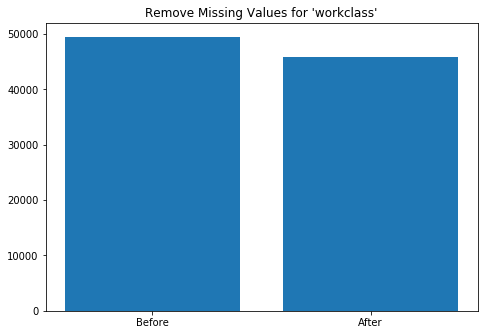

In [8]:
lenAfter = df['workclass']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xaxis = ['Before', 'After']
yaxis = [len(lenBefore), len(lenAfter)]
ax.bar(xaxis,yaxis)
plt.title("Remove Missing Values for 'workclass'")
plt.show()

In [9]:
## Check if there are any duplicate rows
df.duplicated().sum()

208

In [10]:
df = df.drop_duplicates()

# Analyze Data

In [11]:
print(df.shape)
df.describe()

(45641, 14)


,hours-per-week,age,capital-gain,capital-loss,education-num,income
count,45641.000000,45641.000000,45641.000000,45641.000000,45641.00000,45641.000000
mean,40.915120,38.487566,1080.570759,87.546307,10.10438,34417.740606
std,11.966191,13.211451,7426.000706,402.596785,2.54683,26870.885616
min,1.000000,17.000000,0.000000,0.000000,1.00000,107.000000
25%,40.000000,28.000000,0.000000,0.000000,9.00000,13200.000000
50%,40.000000,37.000000,0.000000,0.000000,10.00000,27260.000000
75%,45.000000,47.000000,0.000000,0.000000,12.00000,49515.000000
max,99.000000,90.000000,99999.000000,4356.000000,16.00000,99999.000000


In [13]:
# The highest correlation is 0.408262, education-num and income
df.corr(method ='pearson')

,hours-per-week,age,capital-gain,capital-loss,education-num,income
hours-per-week,1.000000,0.103021,0.083526,0.054216,0.146021,0.347593
age,0.103021,1.000000,0.079491,0.059786,0.038265,0.325923
capital-gain,0.083526,0.079491,1.000000,-0.031643,0.126109,0.287423
capital-loss,0.054216,0.059786,-0.031643,1.000000,0.082126,0.172733
education-num,0.146021,0.038265,0.126109,0.082126,1.000000,0.408262
income,0.347593,0.325923,0.287423,0.172733,0.408262,1.000000


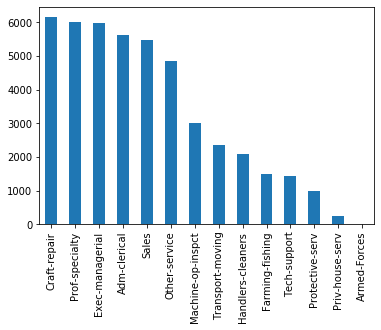

In [14]:
occ=df['occupation'].value_counts()
occ.plot.bar()

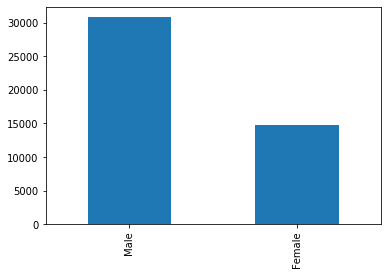

In [15]:
gender=df['gender'].value_counts()
gender.plot.bar()

In [16]:
#Encode the occupations into numbers for the plot below
dictt = dict()
count = 1
for k in list(set(list(df['occupation']))):
    dictt[k]=count
    count+=1
dictt

{'Sales': 1,
 'Protective-serv': 2,
 'Priv-house-serv': 3,
 'Armed-Forces': 4,
 'Machine-op-inspct': 5,
 'Transport-moving': 6,
 'Other-service': 7,
 'Craft-repair': 8,
 'Adm-clerical': 9,
 'Farming-fishing': 10,
 'Tech-support': 11,
 'Prof-specialty': 12,
 'Handlers-cleaners': 13,
 'Exec-managerial': 14}

In [17]:
newdf = df.copy()
for d in dictt:
    newdf=newdf.replace(d, dictt[d])

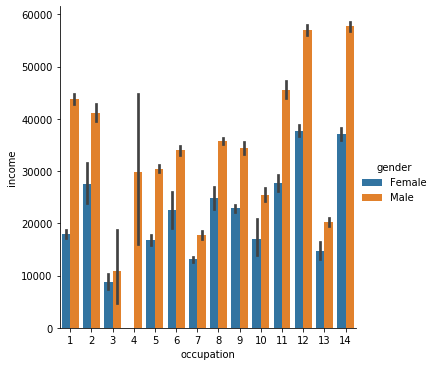

In [18]:
## EDA HERE 
## cat plot of occupation and gender
## we need to show the x label better maybe with numbers
sns.catplot(data=newdf, kind="bar", x="occupation", y="income", hue="gender")

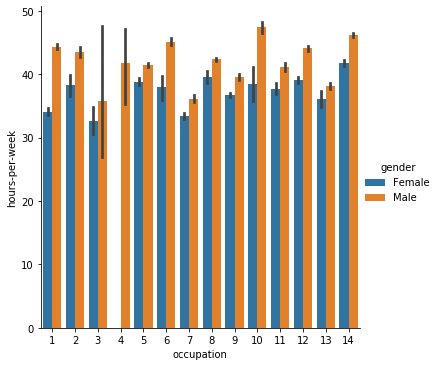

In [19]:
## cat plot of hours and gender
# We can see that men usually work more. To better visualize this, a histplot has been contstructed below
sns.catplot(data=newdf, kind="bar", x="occupation", y="hours-per-week", hue="gender")

99497.03015075377


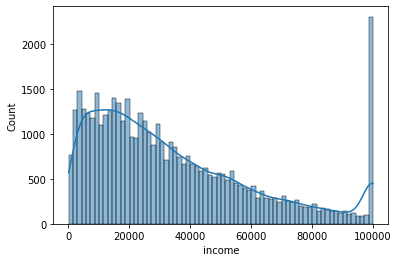

In [20]:
ax = sns.histplot(df['income'], bins=70, kde=True)

kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

##The last bin to remove
print(xs[-2])

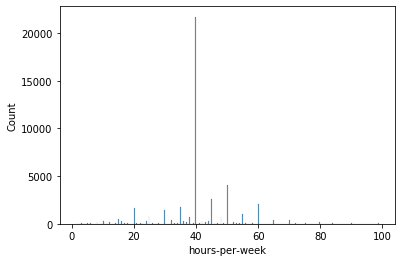

In [21]:
sns.histplot(df['hours-per-week'])
# we need to decrease the number of bins to better understand the plot

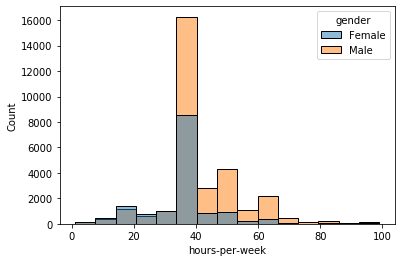

In [22]:
sns.histplot(data=df, x="hours-per-week", bins=15, hue='gender')
#Here we can see the differnece in the hours worked per week between the 2 genders
# we can also see that there are outliers that need to be removed
# It has 2-3 modes

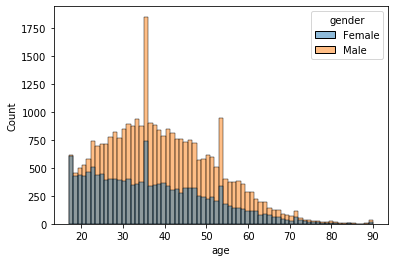

In [23]:
sns.histplot(data=df, x="age", hue="gender")
# It clearly has 2 modes

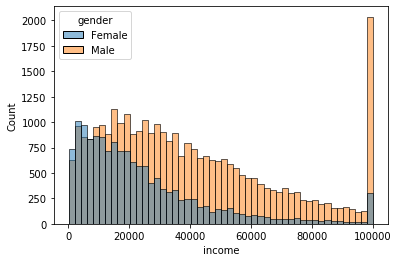

In [24]:
sns.histplot(data=df, x="income", hue="gender")

In [25]:
df.columns

Index(['hours-per-week', 'age', 'capital-gain', 'capital-loss', 'workclass',
       'education', 'education-num', 'marital-status', 'relationship', 'race',
       'gender', 'native-country', 'income', 'occupation'],
      dtype='object')

In [27]:
def drawPlot(xName):

    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x=xName,
        y='income',
        data=df.sort_values(xName),
        ax=axs[0]
    )

    sns.countplot(
        x=xName,
        data=df.sort_values(xName),
        ax=axs[1]
    )

    # Draw median price
    axs[0].axhline(
        y=df['income'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

In [28]:
def find_highIncome(xName, data, n=3, metric=np.median ):
    return data.groupby(xName).agg(metric).sort_values(by=["income"],ascending=False).iloc[:n].index.values.tolist()

In [29]:
def add_in_highIncome(data, highIncome, xName):
    data["in_rich_"+xName] = 0
    mask = data[xName].isin(highIncome)
    data.loc[mask,"in_rich_"+xName] = 1
    return data, "in_rich_"+xName

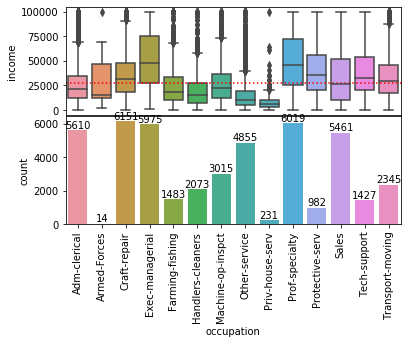

In [30]:
drawPlot("occupation")

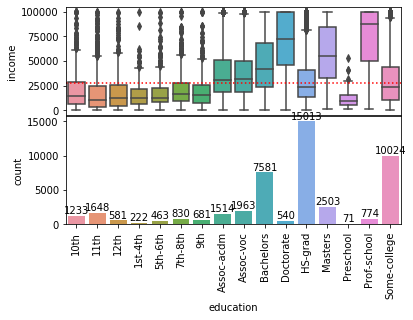

In [31]:
drawPlot("education")

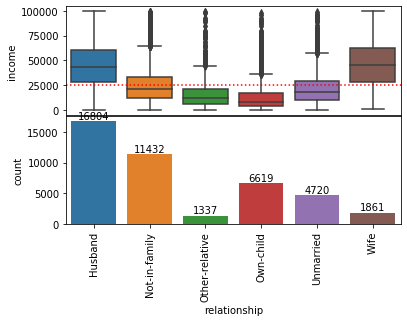

In [87]:
drawPlot("relationship")

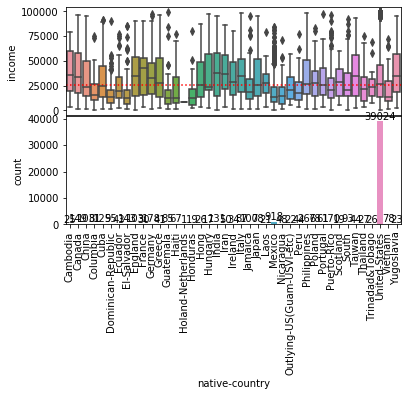

In [88]:
# Very biased, so no feature engineering on this feature
drawPlot("native-country")

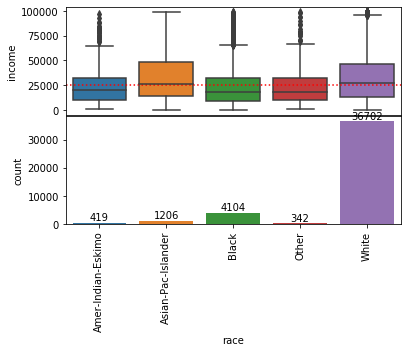

In [89]:
# Very biased, so no feature engineering on this feature
drawPlot("race")

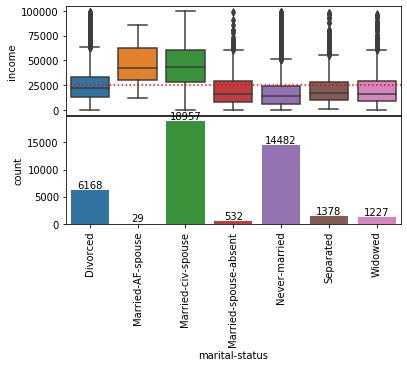

In [99]:
drawPlot("marital-status")

### Check for Outliers

In [32]:
def remove_outliers_sd(data, variable):

    return data.loc[(np.abs(stats.zscore(data[variable])) < 3)]

In [33]:
def remove_outliers_bound(data, variable, lower=-np.inf, upper=np.inf):

    return data.loc[(data[variable] > lower) & (data[variable] < upper)]

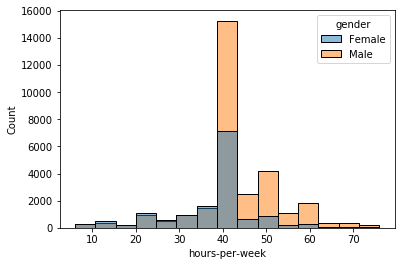

In [34]:
# plot to see how removing the outlier has affected the data
df = remove_outliers_sd(df, "hours-per-week")
sns.histplot(data=df, x="hours-per-week", bins=15, hue='gender')

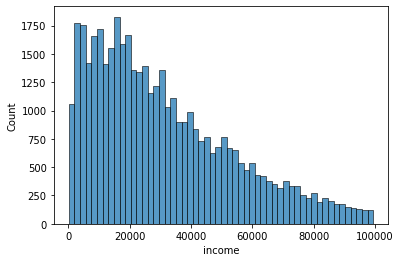

In [35]:
## removing the people who earn more than  99497 
df = remove_outliers_bound(df, 'income', upper = 99497)
sns.histplot(df['income'])

### Decode categorical data

###### Create dummy values for all categorical data

In [36]:
# WE DONT NEED THIS IF WE DO IT IN THE PREPROCESS METHOD
#to_drop = ["workclass", "education", "marital-status", "relationship", "race", "native-country", "occupation", "gender"]
#dummy_vars = pd.get_dummies(df[to_drop])
#dfWithDummy = pd.concat([df.drop(to_drop, axis=1), dummy_vars], axis = 1)
#dfWithDummy.head()

,hours-per-week,age,capital-gain,capital-loss,education-num,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,gender_Female,gender_Male
0,20,40,0,0,13,49100,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,40,21,0,0,10,11500,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,10,17,0,0,7,2600,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,50,51,0,0,9,38997,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
5,38,26,0,1876,13,38524,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


### Making the preprocessing pipeline

In [37]:
def select_columns(data, *columns):
    all_columns = []

    for val in data.columns:
        if val.startswith(columns):
            all_columns.append(val)

    return data.reindex(columns = all_columns)

In [38]:
def standardize_columns(data,epsilon=1e-100):
    standardized_data = (data - np.mean(data))/(np.std(data) + epsilon)
    return standardized_data

In [108]:
def process_data(data):
    # Drop NaNs and duplicates
    data['workclass'] = data['workclass'].replace('?', np.nan)
    data['occupation'] = data['occupation'].replace('?', np.nan)
    data['native-country'] = data['native-country'].replace('?', np.nan)
    data.dropna(how='any', inplace=True)
    data = data.drop_duplicates()
    
    # Feature Engineering
    rich_Occupation = find_highIncome('occupation', data, n=3, metric=np.median )
    data, richOccs = add_in_highIncome(data, rich_Occupation, 'occupation')
    
    rich_Education = find_highIncome('education', data, n=3, metric=np.median )
    data, richEds = add_in_highIncome(data, rich_Education, 'education')

    rich_rel = find_highIncome('relationship', data, n=3, metric=np.median )
    data, richRels = add_in_highIncome(data, rich_rel, 'relationship')

    rich_MS = find_highIncome('marital-status', data, n=1, metric=np.median )
    data, richMS = add_in_highIncome(data, rich_MS, 'marital-status')
    
    # Create dummy variables for categorical
    to_drop = ["workclass", "education", "marital-status", "relationship", "race", "native-country", "occupation", "gender"]
    dummy_vars = pd.get_dummies(data[to_drop])
    data = pd.concat([data.drop(to_drop, axis=1), dummy_vars], axis = 1)
    #display(data)


    data = (
        data
        # Clean Data
        .pipe(remove_outliers_sd, 'hours-per-week') # (681 outliers)
        .pipe(remove_outliers_bound, 'income', upper = 99497 ) 

        # Transform data
        .pipe(select_columns, 
              'age',           
              'capital-gain',
              'capital-loss'                       
              'education-num', 
              'workclass',
              'hours-per-week',
              'income',
              richOccs,
              richEds,
              richRels,
              richMS
             )
    ) 
    
    X = standardize_columns(data).drop(['income'], axis = 1)
    y = data['income']
    
    return X, y

In [ ]:
main_df = pd.read_csv('adult_reconstruction.csv')
X, y = process_data(main_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [110]:
from sklearn import linear_model as lm
alphas = np.arange(0.1, 200.1, .1)
final_model = lm.LassoCV(alphas=alphas,cv=5, max_iter = 10000)

In [111]:
final_model.fit(X_train, y_train)

LassoCV(alphas=array([1.000e-01, 2.000e-01, 3.000e-01, ..., 1.998e+02, 1.999e+02,
       2.000e+02]),
        cv=5, max_iter=10000)

In [115]:
def rmse(actual, predicted):
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    # Normalized RMSE
    return rmse/(max(actual)-min(actual))

In [116]:
y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

In [117]:
train_score = rmse(y_predicted_train, y_train)
test_score = rmse(y_predicted_test, y_test)

print("RMSE Train: ", train_score, " RMSE Test: ", test_score)

RMSE Train:  0.08819946004171139  RMSE Test:  0.10375419824939362
